In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/workflow_data.csv").astype(
    {
        "name": "category",
        "status": "category",
        "conclusion": "category",
        "event": "category",
    }
)

In [3]:
len(df)

488

## Cleaning datetime values
---

In [4]:
df["name"] = df["name"].str.removeprefix(".github/workflows/").str.removesuffix(".yml")

In [5]:
df[ ["created_day", "created_time"] ] = df["created_at"].str.split("T", expand=True)
df[ ["updated_day", "updated_time"] ] = df["updated_at"].str.split("T", expand=True)

In [6]:
df["created_time"] = df["created_time"].str.removesuffix("Z")
df["updated_time"] = df["updated_time"].str.removesuffix("Z")

In [7]:
df["created_dtime"] = pd.to_datetime(df["created_day"] + " " + df["created_time"])

In [8]:
df["updated_dtime"] = pd.to_datetime(df["updated_day"] + " " + df["updated_time"])

In [9]:
df = df.drop(["created_at", "updated_at", "created_day", "created_time", "updated_day", "updated_time"], axis=1)

In [10]:
df.dtypes

id                        int64
name                     object
status                 category
conclusion             category
event                  category
run_attempt               int64
run_number                int64
created_dtime    datetime64[ns]
updated_dtime    datetime64[ns]
dtype: object

In [11]:
df.head()

,id,name,status,conclusion,event,run_attempt,run_number,created_dtime,updated_dtime
0,16102736480,test,completed,success,pull_request,1,361,2025-07-06 20:09:25,2025-07-06 20:13:36
1,16102736476,pr_benchmarks,completed,failure,pull_request,1,85,2025-07-06 20:09:25,2025-07-06 20:34:05
2,16101639498,test,completed,success,pull_request,1,360,2025-07-06 17:47:55,2025-07-06 17:51:58
3,16101639490,pr_benchmarks,completed,failure,pull_request,1,84,2025-07-06 17:47:55,2025-07-06 18:12:39
4,16100155623,test,completed,success,pull_request,1,359,2025-07-06 14:43:23,2025-07-06 14:47:36


In [12]:
df["runtime"] = df["updated_dtime"] - df["created_dtime"]

In [13]:
df["runtime"] = df["runtime"].dt.total_seconds() 

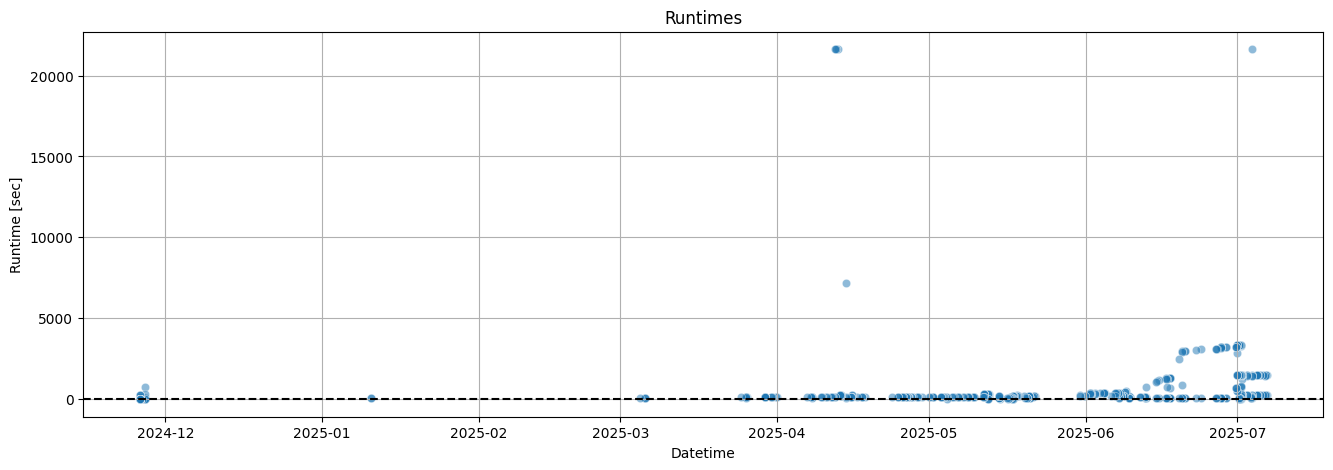

In [14]:
plt.figure(figsize=(16, 5))
sns.scatterplot(x="created_dtime", y="runtime", data=df, alpha=0.5)


plt.title("Runtimes")
plt.xlabel("Datetime")
plt.ylabel("Runtime [sec]")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis

plt.grid(True)
plt.show()

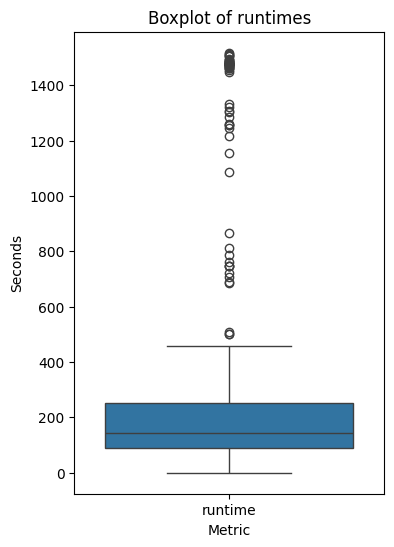

37 not plotted.


In [15]:
temp_df = df.loc[df["runtime"] <= 2000]

melted_data = temp_df.melt(value_vars=["runtime"], var_name="Metric", value_name="Seconds")

# Setting up the boxplot
plt.figure(figsize=(4, 6))
sns.boxplot(x="Metric", y="Seconds", data=melted_data, legend=False)
plt.title("Boxplot of runtimes")

# Showing plot 
plt.show()

print(f"{len(df) - len(temp_df)} not plotted.")

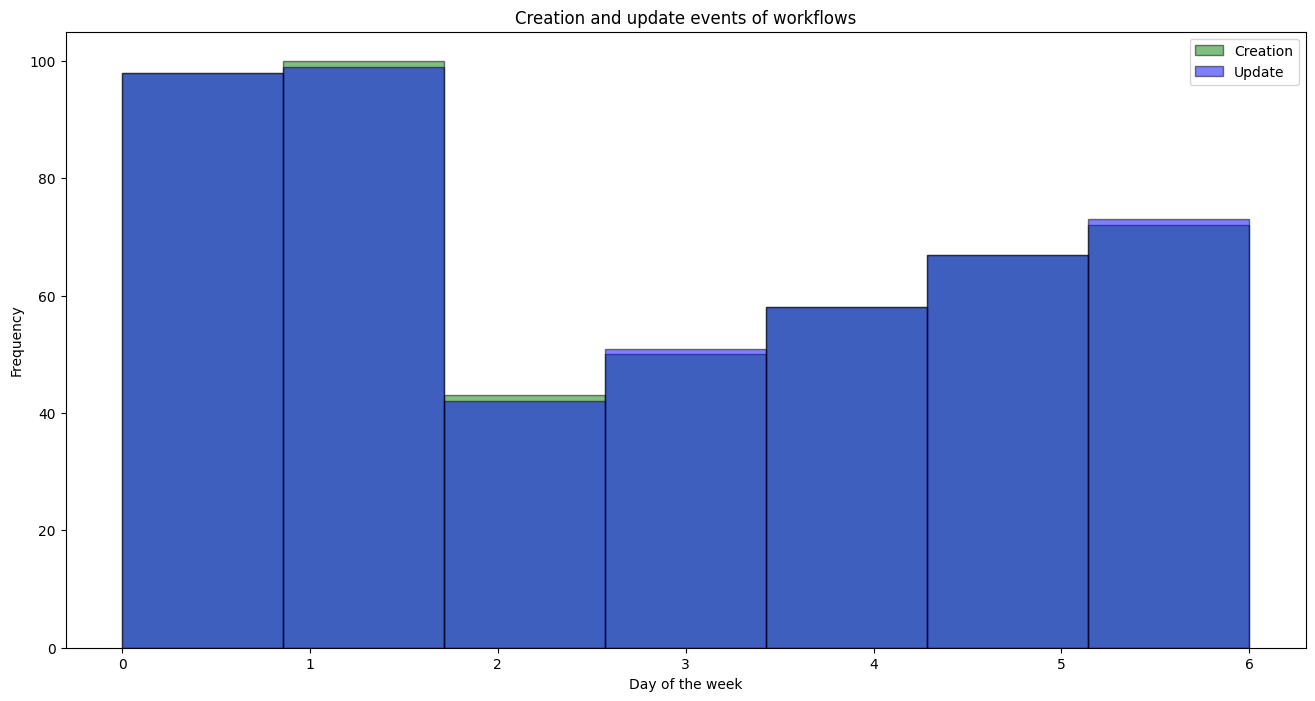

In [16]:
# Overlapping Histograms to compare airtime vs. elapsed time
plt.figure(figsize=(16, 8))

plt.hist(df["created_dtime"].dt.dayofweek, bins=7, alpha=0.5, label="Creation", color="green", edgecolor="black")
plt.hist(df["updated_dtime"].dt.dayofweek, bins=7, alpha=0.5, label="Update", color="blue", edgecolor="black")

plt.title("Creation and update events of workflows")
plt.xlabel("Day of the week")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

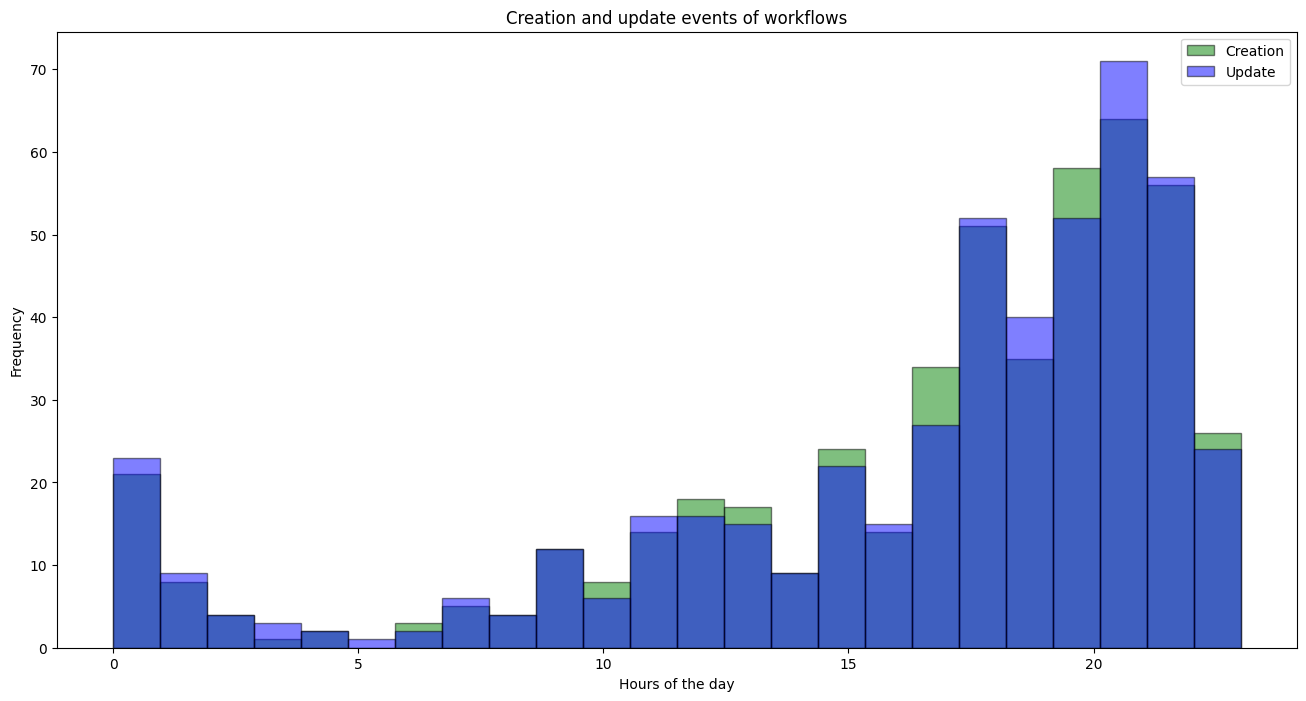

In [17]:
# Overlapping Histograms to compare airtime vs. elapsed time
plt.figure(figsize=(16, 8))

plt.hist(df["created_dtime"].dt.hour, bins=24, alpha=0.5, label="Creation", color="green", edgecolor="black")
plt.hist(df["updated_dtime"].dt.hour, bins=24, alpha=0.5, label="Update", color="blue", edgecolor="black")

plt.title("Creation and update events of workflows")
plt.xlabel("Hours of the day")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

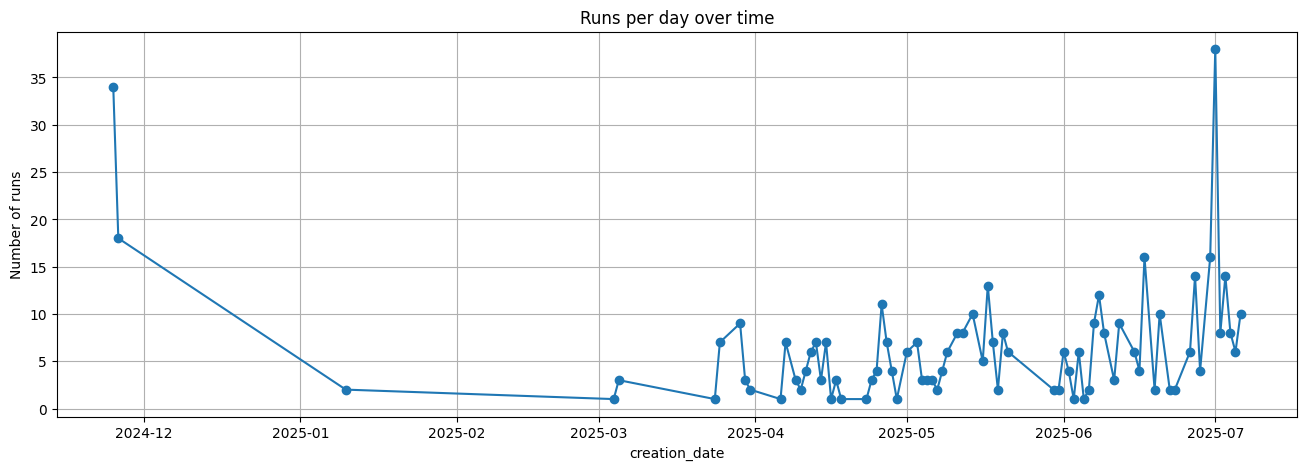

In [18]:
df["creation_date"] = df["created_dtime"].dt.date
counts = df.groupby("creation_date").size()

plt.figure(figsize=(16, 5))
counts.plot(kind="line", marker="o")
plt.grid(True)

# Adding titles and labels
plt.title("Runs per day over time")
plt.ylabel("Number of runs")

plt.show()